In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_auc_score, f1_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# For interpretability:
import shap

In [3]:
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    metrics = {
        "Accuracy": accuracy,
        "Confusion Matrix": confusion,
        "Classification Report": classification,
        "ROC AUC Score": roc_auc,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    }
    return metrics

In [4]:
def plot_feature_importances(feature_names, importances, title="Feature Importances"):
    imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    # Filter out features with zero importance
    imp_df = imp_df[imp_df['Importance'] != 0]
    imp_df = imp_df.sort_values('Importance', ascending=False)
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=imp_df)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def print_metrics(metrics):
    """Print the evaluation metrics"""
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}:\n{metric_value}\n{'-' * 40}")

In [5]:
def tune_and_evaluate_model(model, param_grid, X, y, feature_names, model_name, dataset_name, results_path="results.csv"):
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    # Grid Search CV
    print(f"Running GridSearch for {model_name} on {dataset_name}")
    grid_search = GridSearchCV(model, param_grid, scoring='f1', cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"Best params for {model_name} on {dataset_name}: {grid_search.best_params_}")

    # Evaluate
    metrics = evaluate_model(best_model, X_test, y_test)
    print(f"\n{model_name} on {dataset_name} Metrics:")
    print_metrics(metrics)

    # Interpretability
    if isinstance(best_model, LogisticRegression):
            # Coefficients interpretation
            coefs = best_model.coef_[0]
            plot_feature_importances(feature_names, coefs, title=f"{model_name} ({dataset_name}) Coefficients")

    elif isinstance(best_model, SVC):
        # If linear SVC, can use coefficients
        # If nonlinear (like RBF), use SHAP for interpretation
        if best_model.kernel == 'linear':
            coefs = best_model.coef_[0]
            plot_feature_importances(feature_names, coefs, title=f"{model_name} ({dataset_name}) Coefficients")
        else:
            # Use SHAP for nonlinear SVC
            explainer = shap.KernelExplainer(best_model.decision_function, X_train.sample(100))
            shap_values = explainer.shap_values(X_test.sample(10))
            shap.summary_plot(shap_values, X_test.sample(10), feature_names=feature_names)

    elif isinstance(best_model, XGBClassifier):
        # For XGBoost, we can use the built-in feature_importances_ or SHAP.
        # SHAP's TreeExplainer is more accurate and efficient for tree-based models.
        # Using SHAP TreeExplainer
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, feature_names=feature_names)

    # Save results to CSV
    result_row = {
        "Model": model_name,
        "Dataset": dataset_name,
        "Accuracy": metrics["Accuracy"],
        "Precision": metrics["Precision"],
        "Recall": metrics["Recall"],
        "F1": metrics["F1 Score"],
        "ROC_AUC": metrics["ROC AUC Score"]
    }

    # Append to CSV
    try:
        existing_df = pd.read_csv(results_path)
        existing_df = pd.concat([existing_df, pd.DataFrame([result_row])], ignore_index=True)
        existing_df.to_csv(results_path, index=False)
    except FileNotFoundError:
        pd.DataFrame([result_row]).to_csv(results_path, index=False)

    return best_model, metrics

In [6]:
merged_dataset = pd.read_csv("datasets/merged_dataset.csv").sample(frac=1).reset_index(drop=True)
y_merged = merged_dataset['Depression'].to_numpy()
x_merged = merged_dataset.drop(columns=['Depression', 'id', 'Name']).to_numpy()
merged_feature = merged_dataset.drop(columns=['Depression', 'id', 'Name']).columns.tolist()

# should be the missing one
mean_dataset = pd.read_csv("datasets/mean_data.csv").sample(frac=1).reset_index(drop=True)
x_mean = mean_dataset.iloc[:, 2:-1].to_numpy()
y_mean = mean_dataset.iloc[:, -1].to_numpy()
mean_feature = mean_dataset.columns[2:-1].tolist()


marking_missing_dataset = pd.read_csv("datasets/marking_missing_data.csv").sample(frac=1).reset_index(drop=True)
x_marking_missing = marking_missing_dataset.iloc[:, 2:-1].to_numpy()
y_marking_missing = marking_missing_dataset.iloc[:, -1].to_numpy()
marking_missing_feature = marking_missing_dataset.columns[2:-1].tolist()


knn_dataset = pd.read_csv("datasets/knn_data.csv").sample(frac=1).reset_index(drop=True)
x_knn = knn_dataset.iloc[:, 2:-1].to_numpy()
y_knn = knn_dataset.iloc[:, -1].to_numpy()
knn_feature = knn_dataset.columns[2:-1].tolist()



#knn_dataset = pd.read_csv("data_generated/knn_data.csv").sample(frac=1).reset_index(drop=True)
#x_knn_dataset = knn_dataset.iloc[:, 2:-1].to_numpy()
#y_knn_dataset = knn_dataset.iloc[:, -1].to_numpy()
#knn_feature_names = knn_dataset.columns[2:-1].tolist()

# knn_dataset_pca = pd.read_csv("data_generated/knn_dataset_pca.csv").sample(frac=1).reset_index(drop=True)
# x_knn_dataset_pca = knn_dataset_pca.iloc[:, :-1].to_numpy()
# y_knn_dataset_pca = knn_dataset_pca.iloc[:, -1].to_numpy()

# mean_dataset_pca = pd.read_csv("data_generated/mean_dataset_pca.csv").sample(frac=1).reset_index(drop=True)
# x_mean_dataset_pca = mean_dataset_pca.iloc[:, :-1].to_numpy()
# y_mean_dataset_pca = mean_dataset_pca.iloc[:, -1].to_numpy()

# merged_dataset_pca = pd.read_csv("data_generated/merged_features_dataset_pca.csv").sample(frac=1).reset_index(drop=True)
# x_merged_dataset_pca = merged_dataset_pca.iloc[:, :-1].to_numpy()
# y_merged_dataset_pca = merged_dataset_pca.iloc[:, -1].to_numpy()

# knn_dataset_pca_feature_names = knn_dataset_pca.columns[:-1].tolist()
# mean_dataset_pca_feature_names = mean_dataset_pca.columns[:-1].tolist()
# merged_dataset_pca_feature_names = merged_dataset_pca.columns[:-1].tolist()

In [8]:
knn_data_pca = pd.read_csv("datasets/knn_dataset_pca.csv").sample(frac=1).reset_index(drop=True)

In [39]:
datasets = [
    {
        "name": "Merged Dataset",
        "x": x_merged,
        "y": y_merged,
        "feature_names": merged_feature
    },
    {
        "name": "Mean Dataset",
        "x": x_mean,
        "y": y_mean,
        "feature_names": mean_feature
    },
    {
        "name": "Marking Missing Dataset",
        "x": x_marking_missing,
        "y": y_marking_missing,
        "feature_names": marking_missing_feature
    },
    {
        "name": "KNN Dataset",
        "x": x_knn,
        "y": y_knn,
        "feature_names": knn_feature
    }

    # {
    #     "name": "KNN_Dataset",
    #     "x": x_knn_dataset,
    #     "y": y_knn_dataset,
    #     "feature_names": knn_feature_names
    # },
    # {
    #     "name": "Mean Dataset PCA",
    #     "x": x_mean_dataset_pca,
    #     "y": y_mean_dataset_pca,
    #     "feature_names": mean_dataset_pca_feature_names
    # },
    # {
    #     "name": "Merged Dataset PCA",
    #     "x": x_merged_dataset_pca,
    #     "y": y_merged_dataset_pca,
    #     "feature_names": merged_dataset_pca_feature_names
    # },
    # {
    #     "name": "KNN Dataset PCA",
    #     "x": x_knn_dataset_pca,
    #     "y": y_knn_dataset_pca,
    #     "feature_names": knn_dataset_pca_feature_names
    # }
]


In [16]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

models = [
    LogisticRegression(max_iter=5000, random_state=42),
    KNeighborsClassifier(),
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', device='cuda'),
    GaussianNB()
]

## KNN

In [17]:
# K-Nearest Neighbors on Merged Dataset
knn_param_grid = {
    'n_neighbors': [5, 10, 20],  # Number of neighbors to use
    'metric': ['euclidean', 'manhattan'],  # Distance metric
}
knn_model, knn_metrics = tune_and_evaluate_model(
    models[1], knn_param_grid, x_merged, y_merged, merged_feature, "K-Nearest Neighbors", "Merged Dataset"
)

Running GridSearch for K-Nearest Neighbors on Merged Dataset
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for K-Nearest Neighbors on Merged Dataset: {'metric': 'manhattan', 'n_neighbors': 20}

K-Nearest Neighbors on Merged Dataset Metrics:
Accuracy:
0.9099222896133434
----------------------------------------
Confusion Matrix:
[[16641   628]
 [ 1273  2562]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     17269
           1       0.80      0.67      0.73      3835

    accuracy                           0.91     21104
   macro avg       0.87      0.82      0.84     21104
weighted avg       0.91      0.91      0.91     21104

----------------------------------------
ROC AUC Score:
0.8158458121406327
----------------------------------------
F1 Score:
0.7293950177935943
----------------------------------------
Precision:
0.8031347962382445
-------

In [18]:
# K-Nearest Neighbors on Merged Dataset
knn_param_grid = {
    'n_neighbors': [5, 10, 20],  # Number of neighbors to use
    'metric': ['euclidean', 'manhattan'],  # Distance metric
}
knn_model, knn_metrics = tune_and_evaluate_model(
    models[1], knn_param_grid, x_knn, y_knn, knn_feature, "K-Nearest Neighbors", "KNN Dataset"
)

Running GridSearch for K-Nearest Neighbors on KNN Dataset
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for K-Nearest Neighbors on KNN Dataset: {'metric': 'manhattan', 'n_neighbors': 20}

K-Nearest Neighbors on KNN Dataset Metrics:
Accuracy:
0.9169391139540394
----------------------------------------
Confusion Matrix:
[[16615   655]
 [ 1098  2737]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     17270
         1.0       0.81      0.71      0.76      3835

    accuracy                           0.92     21105
   macro avg       0.87      0.84      0.85     21105
weighted avg       0.91      0.92      0.91     21105

----------------------------------------
ROC AUC Score:
0.8378813295093118
----------------------------------------
F1 Score:
0.7574373875743738
----------------------------------------
Precision:
0.8068985849056604
----------------

In [20]:
# K-Nearest Neighbors on Merged Dataset
knn_param_grid = {
    'n_neighbors': [5, 10, 20],  # Number of neighbors to use
    'metric': ['euclidean', 'manhattan'],  # Distance metric
}
knn_model, knn_metrics = tune_and_evaluate_model(
    models[1], knn_param_grid, x_marking_missing, y_marking_missing, marking_missing_feature, "K-Nearest Neighbors", "Marking Missing Dataset"
)

Running GridSearch for K-Nearest Neighbors on Marking Missing Dataset
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for K-Nearest Neighbors on Marking Missing Dataset: {'metric': 'manhattan', 'n_neighbors': 20}

K-Nearest Neighbors on Marking Missing Dataset Metrics:
Accuracy:
0.9075100687040986
----------------------------------------
Confusion Matrix:
[[16649   621]
 [ 1331  2504]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     17270
           1       0.80      0.65      0.72      3835

    accuracy                           0.91     21105
   macro avg       0.86      0.81      0.83     21105
weighted avg       0.90      0.91      0.90     21105

----------------------------------------
ROC AUC Score:
0.8084875989820393
----------------------------------------
F1 Score:
0.7195402298850575
----------------------------------------
Precision:

## Naive Bayes

In [26]:
# Naive Bayes on Merged Dataset
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7],  # Smoothing parameter for Gaussian Naive Bayes
}
nb_model, nb_metrics = tune_and_evaluate_model(
    models[3], nb_param_grid, x_merged, y_merged, merged_feature, "Naive Bayes", "Merged Dataset"
)


Running GridSearch for Naive Bayes on Merged Dataset
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best params for Naive Bayes on Merged Dataset: {'var_smoothing': 1e-09}

Naive Bayes on Merged Dataset Metrics:
Accuracy:
0.6833775587566339
----------------------------------------
Confusion Matrix:
[[11148  6121]
 [  561  3274]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     17269
           1       0.35      0.85      0.49      3835

    accuracy                           0.68     21104
   macro avg       0.65      0.75      0.63     21104
weighted avg       0.84      0.68      0.72     21104

----------------------------------------
ROC AUC Score:
0.7496328024616689
----------------------------------------
F1 Score:
0.49493575207860924
----------------------------------------
Precision:
0.3484832357637041
----------------------------------------
Recall:

In [ ]:
# Naive Bayes on Merged Dataset
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7],  # Smoothing parameter for Gaussian Naive Bayes
}
nb_model, nb_metrics = tune_and_evaluate_model(
    models[3], nb_param_grid, x_marking_missing, y_marking_missing, marking_missing_feature, "Naive Bayes", "Marking Missing Dataset"
)


In [ ]:
# Naive Bayes on Merged Dataset
nb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7],  # Smoothing parameter for Gaussian Naive Bayes
}
nb_model, nb_metrics = tune_and_evaluate_model(
    models[3], nb_param_grid, x_knn, y_knn, knn_feature, "Naive Bayes", "KNN Dataset"
)


## Logistic Regression

Running GridSearch for Logistic Regression on Merged Dataset
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-

Best params for Logistic Regression on Merged Dataset: {'C': 10, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'saga'}

Logistic Regression on Merged Dataset Metrics:
Accuracy:
0.9251326762699015
----------------------------------------
Confusion Matrix:
[[16711   558]
 [ 1022  2813]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     17269
           1       0.83      0.73      0.78      3835

    accuracy                           0.93     21104
   macro avg       0.89      0.85      0.87     21104
weighted avg       0.92      0.93      0.92     21104

----------------------------------------
ROC AUC Score:
0.8505974674985276
----------------------------------------
F1 Score:
0.7807382736608381
----------------------------------------
Precision:
0.8344704835360427
----------------------------------------
Recall:
0.7335071707953064
----------------------------------------


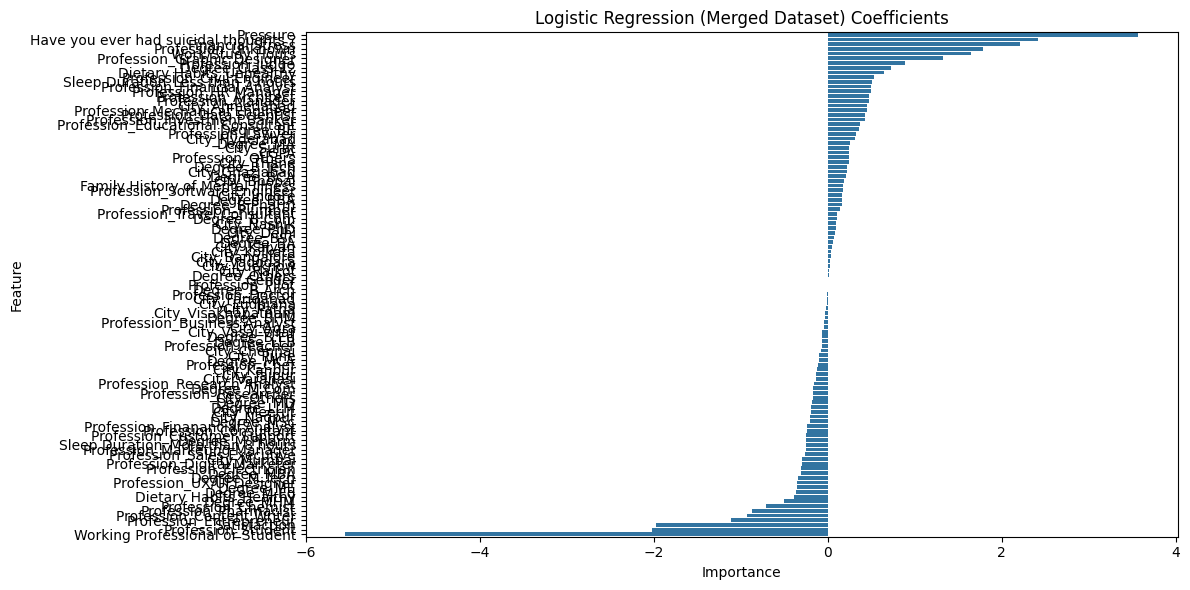

In [28]:
# Logistic Regression on Merged Dataset
lr_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]
}
lr_model, lr_metrics = tune_and_evaluate_model(models[0], lr_param_grid, x_merged, y_merged, merged_feature, "Logistic Regression", "Merged Dataset")

Running GridSearch for Logistic Regression on Mean Dataset
Fitting 5 folds for each of 192 candidates, totalling 960 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-

Best params for Logistic Regression on Mean Dataset: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Logistic Regression on Mean Dataset Metrics:
Accuracy:
0.9225775882492301
----------------------------------------
Confusion Matrix:
[[16699   571]
 [ 1063  2772]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     17270
           1       0.83      0.72      0.77      3835

    accuracy                           0.92     21105
   macro avg       0.88      0.84      0.86     21105
weighted avg       0.92      0.92      0.92     21105

----------------------------------------
ROC AUC Score:
0.8448765258276216
----------------------------------------
F1 Score:
0.7723599888548343
----------------------------------------
Precision:
0.829195333532755
----------------------------------------
Recall:
0.7228161668839634
----------------------------------------


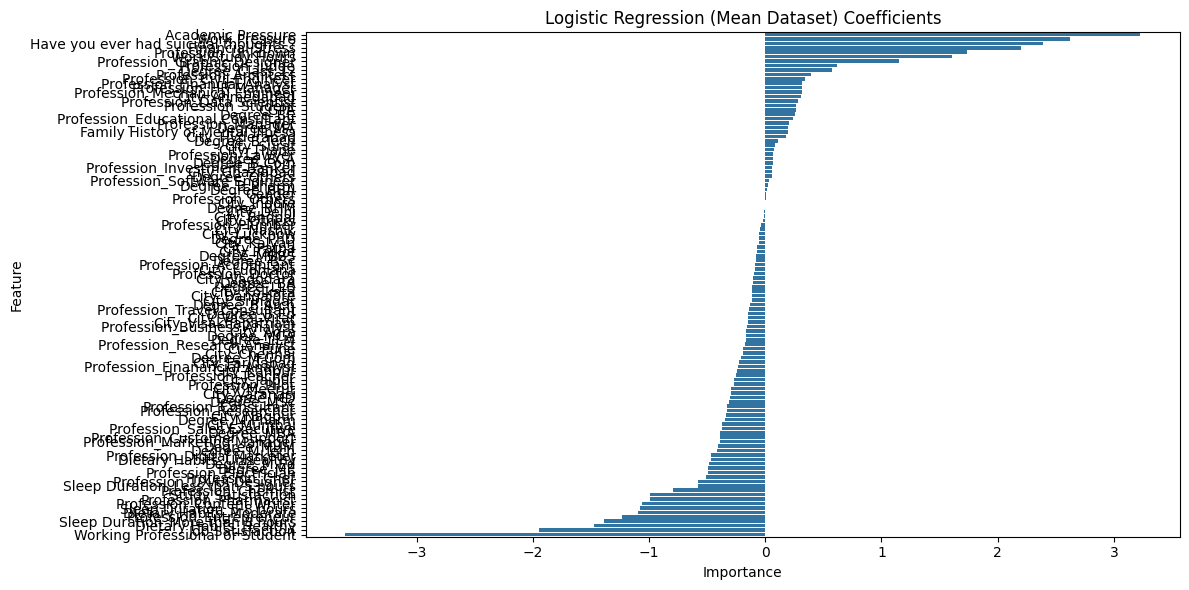

In [44]:
lr_param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]
}
lr_model, lr_metrics = tune_and_evaluate_model(models[0], lr_param_grid, x_mean, y_mean, mean_feature, "Logistic Regression", "Mean Dataset")

Running GridSearch for Logistic Regression on Marking Missing Dataset
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for Logistic Regression on Marking Missing Dataset: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression on Marking Missing Dataset Metrics:
Accuracy:
0.919166074389955
----------------------------------------
Confusion Matrix:
[[16634   636]
 [ 1070  2765]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     17270
           1       0.81      0.72      0.76      3835

    accuracy                           0.92     21105
   macro avg       0.88      0.84      0.86     21105
weighted avg       0.92      0.92      0.92     21105

----------------------------------------
ROC AUC Score:
0.8420820030665653
----------------------------------------
F1 Score:
0.7642343836373687
----------------------------------------
Prec

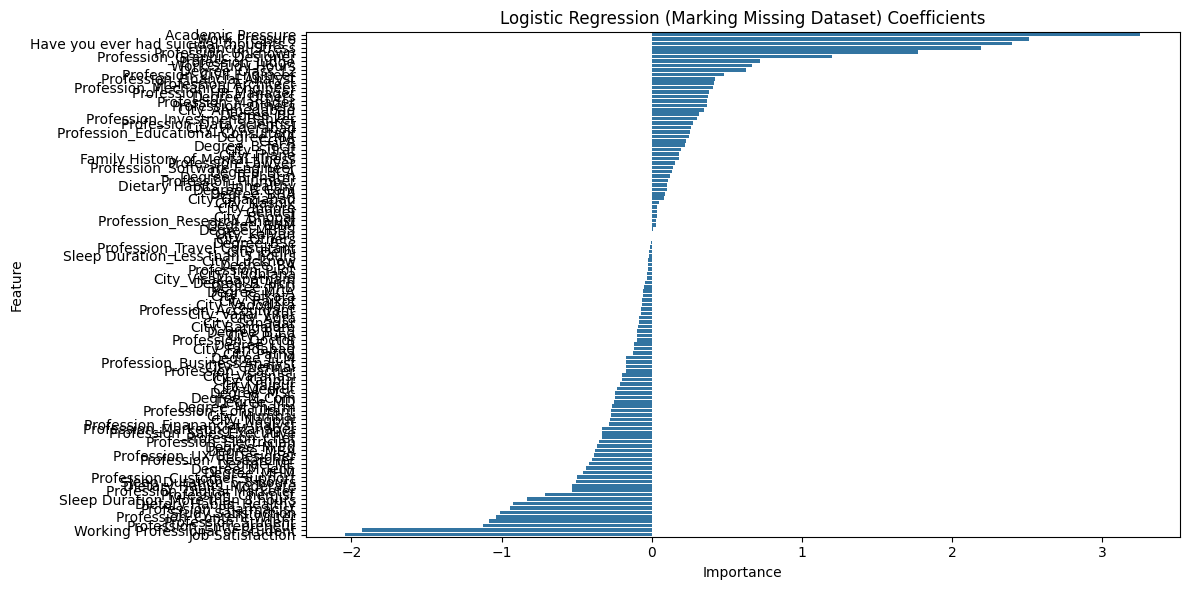

In [29]:

# Logistic Regression on Merged Dataset
lr_param_grid = {
    'penalty': ['l1', 'l2'],  # Focus on the most commonly used penalties.
    'C': [0.1, 1, 10],        # Narrow the range of regularization strengths.
    'solver': ['liblinear', 'saga'],  # Use solvers that support these penalties.
}

lr_model, lr_metrics = tune_and_evaluate_model(models[0], lr_param_grid, x_marking_missing, y_marking_missing, marking_missing_feature, "Logistic Regression", "Marking Missing Dataset")

Running GridSearch for Logistic Regression on KNN Dataset
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params for Logistic Regression on KNN Dataset: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}

Logistic Regression on KNN Dataset Metrics:
Accuracy:
0.9373134328358209
----------------------------------------
Confusion Matrix:
[[16684   586]
 [  737  3098]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     17270
         1.0       0.84      0.81      0.82      3835

    accuracy                           0.94     21105
   macro avg       0.90      0.89      0.89     21105
weighted avg       0.94      0.94      0.94     21105

----------------------------------------
ROC AUC Score:
0.886945506183334
----------------------------------------
F1 Score:
0.8240457507647293
----------------------------------------
Precision:
0.8409337676438654
---------------

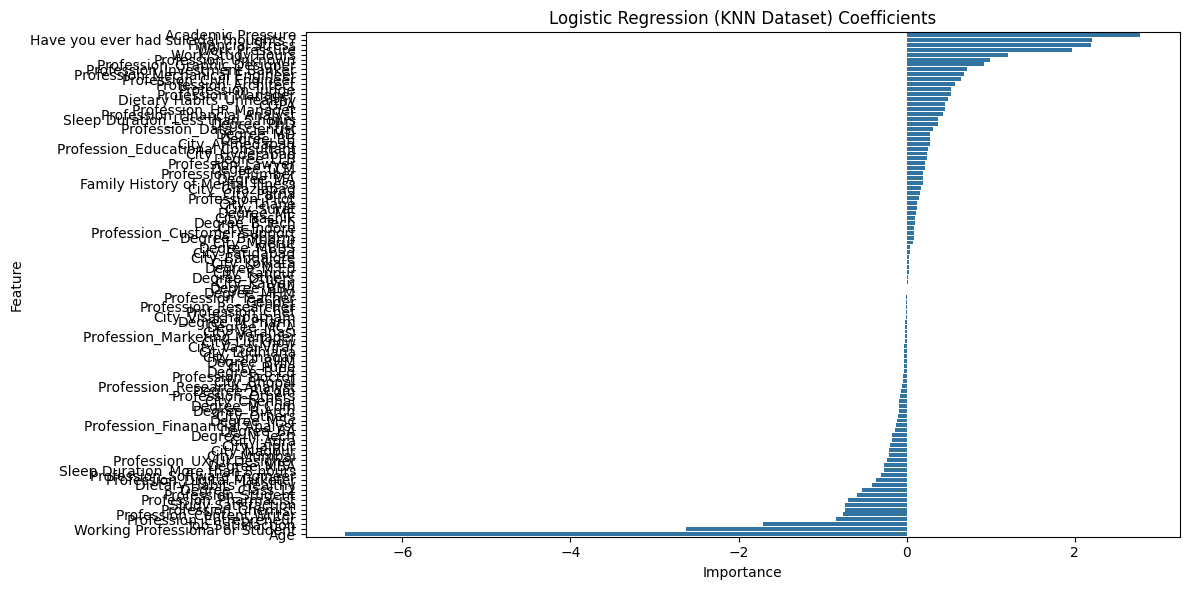

In [30]:
# Logistic Regression on Merged Dataset
lr_param_grid = {
    'penalty': ['l1', 'l2'],  # Focus on the most commonly used penalties.
    'C': [0.1, 1, 10],        # Narrow the range of regularization strengths.
    'solver': ['liblinear', 'saga'],  # Use solvers that support these penalties.
}

lr_model, lr_metrics = tune_and_evaluate_model(models[0], lr_param_grid, x_knn, y_knn, knn_feature, "Logistic Regression", "KNN Dataset")

## XGBoost

Running GridSearch for XGBoost on Merged Dataset
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:07:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.p

Best params for XGBoost on Merged Dataset: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

XGBoost on Merged Dataset Metrics:
Accuracy:
0.9260803639120546
----------------------------------------
Confusion Matrix:
[[16707   562]
 [  998  2837]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     17269
           1       0.83      0.74      0.78      3835

    accuracy                           0.93     21104
   macro avg       0.89      0.85      0.87     21104
weighted avg       0.92      0.93      0.92     21104

----------------------------------------
ROC AUC Score:
0.8536107273488158
----------------------------------------
F1 Score:
0.784351672656898
----------------------------------------
Precision:
0.8346572521329803
----------------------------------------
Recall:
0.7397653194263364
----------------------------------------


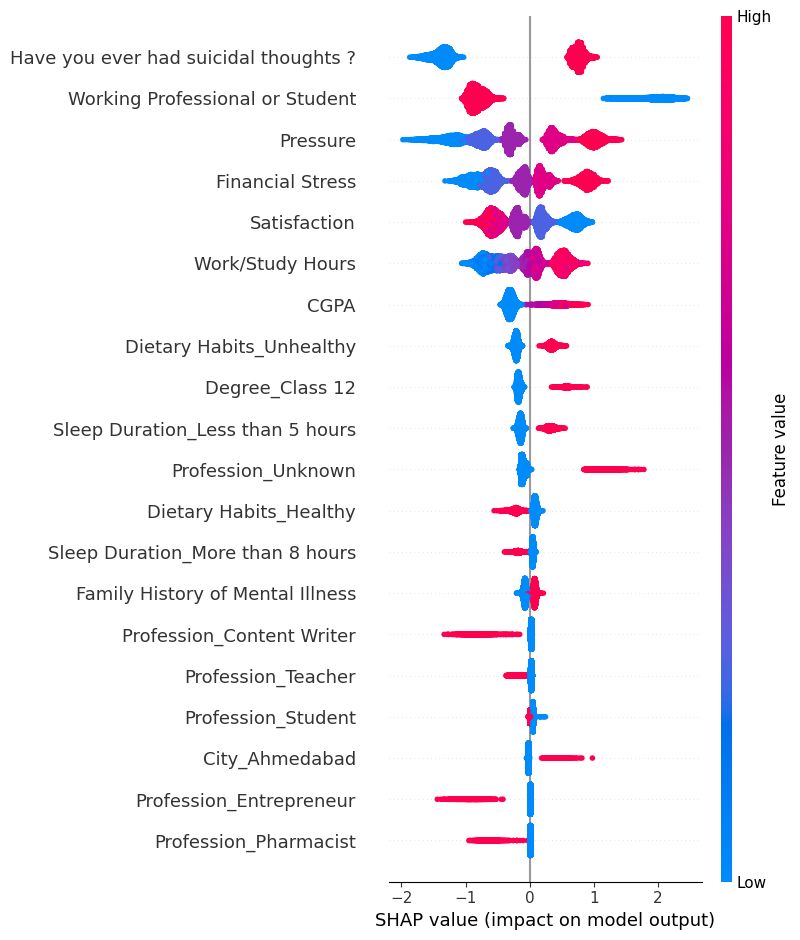

In [24]:
# XGBoost on merged dataset
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model, xgb_metrics = tune_and_evaluate_model(models[2], xgb_param_grid, x_merged, y_merged, merged_feature, "XGBoost", "Merged Dataset")

Running GridSearch for XGBoost on Mean Dataset
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.p

Best params for XGBoost on Mean Dataset: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}

XGBoost on Mean Dataset Metrics:
Accuracy:
0.9239042880833925
----------------------------------------
Confusion Matrix:
[[16705   565]
 [ 1041  2794]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     17270
           1       0.83      0.73      0.78      3835

    accuracy                           0.92     21105
   macro avg       0.89      0.85      0.87     21105
weighted avg       0.92      0.92      0.92     21105

----------------------------------------
ROC AUC Score:
0.8479185555888569
----------------------------------------
F1 Score:
0.7767584097859327
----------------------------------------
Precision:
0.8317951771360524
----------------------------------------
Recall:
0.7285528031290743
----------------------------------------


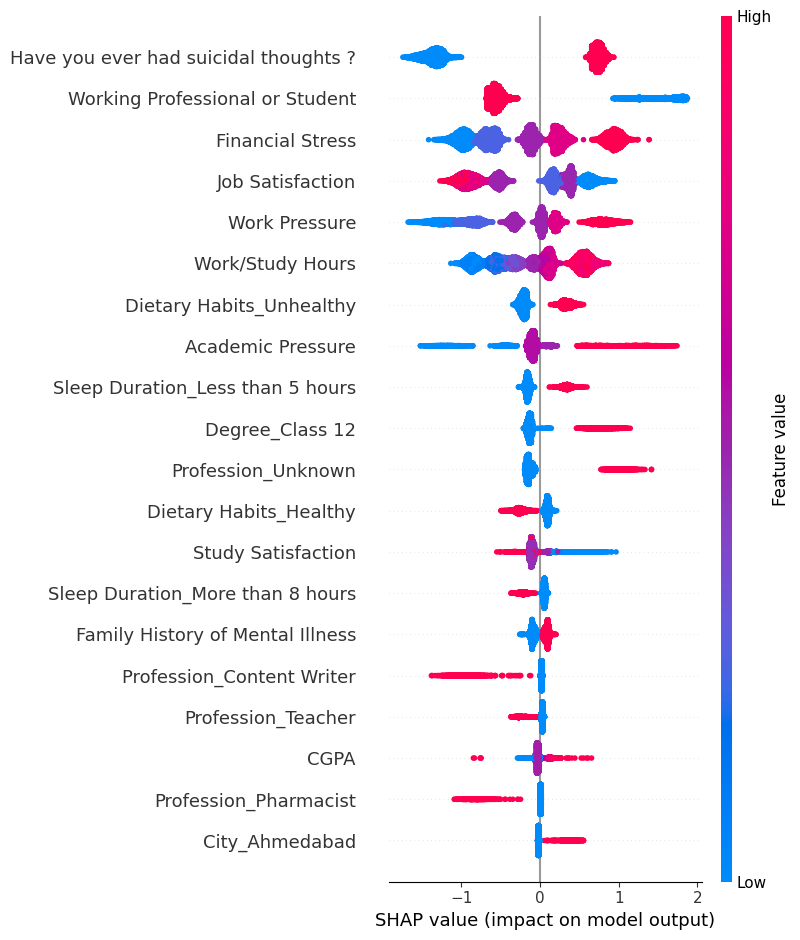

In [45]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model, xgb_metrics = tune_and_evaluate_model(models[2], xgb_param_grid, x_mean, y_mean, mean_feature, "XGBoost", "Mean Dataset")

Running GridSearch for XGBoost on Marking Missing Dataset
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:29] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:10:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.p

Best params for XGBoost on Marking Missing Dataset: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}

XGBoost on Marking Missing Dataset Metrics:
Accuracy:
0.9182184316512675
----------------------------------------
Confusion Matrix:
[[16603   667]
 [ 1059  2776]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     17270
           1       0.81      0.72      0.76      3835

    accuracy                           0.92     21105
   macro avg       0.87      0.84      0.86     21105
weighted avg       0.92      0.92      0.92     21105

----------------------------------------
ROC AUC Score:
0.8426186519946641
----------------------------------------
F1 Score:
0.7628469359714207
----------------------------------------
Precision:
0.806273598605867
----------------------------------------
Recall:
0.7238591916558018
--------------------------------

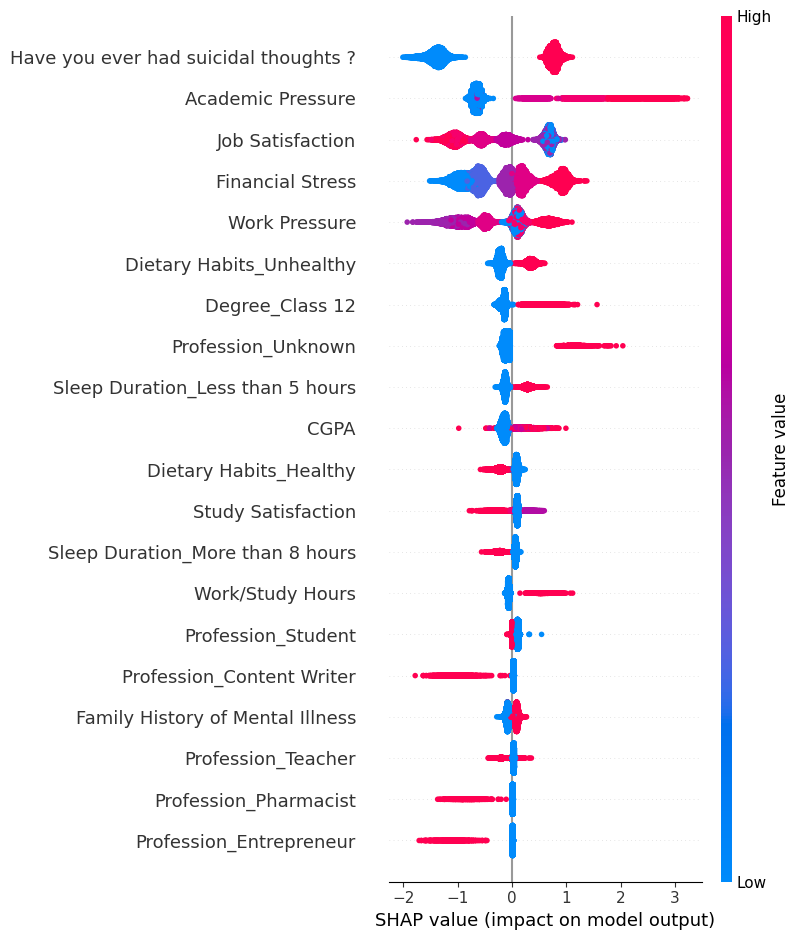

In [25]:
# XGBoost on merged dataset
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model, xgb_metrics = tune_and_evaluate_model(models[2], xgb_param_grid, x_marking_missing, y_marking_missing, marking_missing_feature, "XGBoost", "Marking Missing Dataset")

Running GridSearch for XGBoost on KNN Dataset
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.p

Best params for XGBoost on KNN Dataset: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

XGBoost on KNN Dataset Metrics:
Accuracy:
0.9408197109689647
----------------------------------------
Confusion Matrix:
[[16688   582]
 [  667  3168]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96     17270
         1.0       0.84      0.83      0.84      3835

    accuracy                           0.94     21105
   macro avg       0.90      0.90      0.90     21105
weighted avg       0.94      0.94      0.94     21105

----------------------------------------
ROC AUC Score:
0.8961877806960394
----------------------------------------
F1 Score:
0.8353328938694793
----------------------------------------
Precision:
0.8448
----------------------------------------
Recall:
0.8260756192959583
----------------------------------------


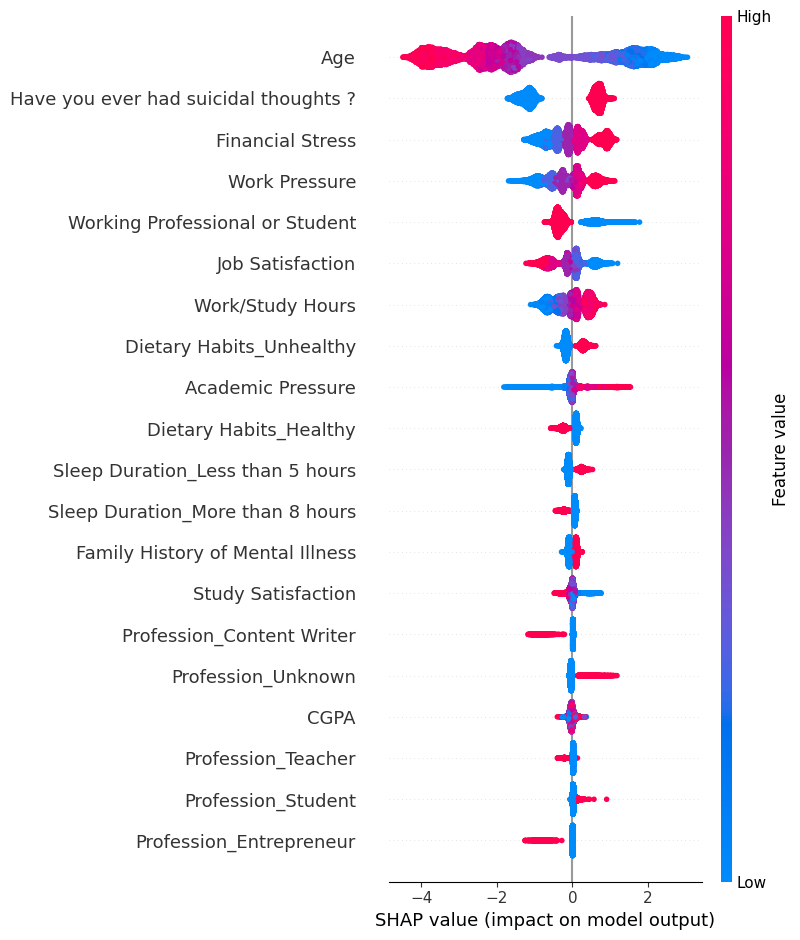

In [27]:
# XGBoost on merged dataset
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model, xgb_metrics = tune_and_evaluate_model(models[2], xgb_param_grid, x_knn, y_knn, knn_feature, "XGBoost", "KNN Dataset")

In [9]:
final_results = pd.read_csv("results.csv")
final_results.sort_values(by='F1', ascending=False, inplace=True)
final_results

,Model,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC
8,XGBoost,KNN Dataset,0.940820,0.844800,0.826076,0.835333,0.896188
14,XGBoost,KNN PCA Dataset,0.937929,0.833730,0.822425,0.828039,0.893002
11,Logistic Regression,KNN Dataset,0.937313,0.840934,0.807823,0.824046,0.886946
16,Logistic Regression,KNN PCA Dataset,0.935797,0.835861,0.804694,0.819981,0.884802
6,XGBoost,Merged Features Dataset,0.926080,0.834657,0.739765,0.784352,0.853611
9,Logistic Regression,Merged Features Dataset,0.925133,0.834470,0.733507,0.780738,0.850597
13,XGBoost,Mean Dataset,0.923904,0.831795,0.728553,0.776758,0.847919
15,XGBoost,Merged PCA Dataset,0.922527,0.824101,0.729335,0.773828,0.847382
17,Logistic Regression,Merged PCA Dataset,0.922100,0.823061,0.727771,0.772488,0.846513
12,Logistic Regression,Mean Dataset,0.922578,0.829195,0.722816,0.772360,0.844877


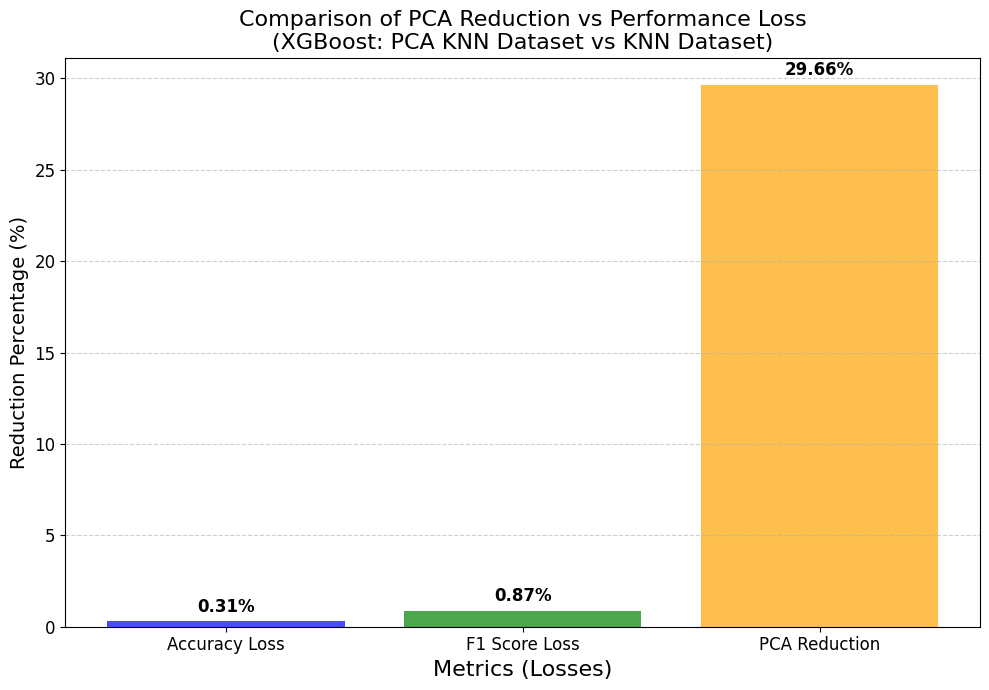

In [22]:
import pandas as pd
import matplotlib.pyplot as plt


xgboost_knn_data = final_results[(final_results['Model'] == 'XGBoost') & (final_results['Dataset'] == 'KNN Dataset')]
xgboost_knn_pca_data = final_results[(final_results['Model'] == 'XGBoost') & (final_results['Dataset'] == 'KNN PCA Dataset')]


accuracy_original = xgboost_knn_data['Accuracy'].values[0]
f1_original = xgboost_knn_data['F1'].values[0]
accuracy_pca = xgboost_knn_pca_data['Accuracy'].values[0]
f1_pca = xgboost_knn_pca_data['F1'].values[0]

# Calculating percentage reductions
accuracy_reduction = ((accuracy_original - accuracy_pca) / accuracy_original) * 100
f1_reduction = ((f1_original - f1_pca) / f1_original) * 100

# Calculating PCA reduction percentage
original_features = knn_dataset.shape[1]
pca_features = knn_data_pca.shape[1]
pca_reduction_percentage = ((original_features - pca_features) / original_features) * 100


plot_data = pd.DataFrame({
    'Metric': ['Accuracy Loss', 'F1 Score Loss', 'PCA Reduction'],
    'Percentage Reduction': [accuracy_reduction, f1_reduction, pca_reduction_percentage]
})


plt.figure(figsize=(10, 7))
bars = plt.bar(plot_data['Metric'], plot_data['Percentage Reduction'], color=['blue', 'green', 'orange'], alpha=0.7)


for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3, f'{bar.get_height():.2f}%', 
             ha='center', va='bottom', fontsize=12, color='black', weight='bold')


plt.title('Comparison of PCA Reduction vs Performance Loss\n(XGBoost: PCA KNN Dataset vs KNN Dataset)', fontsize=16)
plt.ylabel('Reduction Percentage (%)', fontsize=14)
plt.xlabel('Metrics (Losses)', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig("pca_knn_vs_knn.png", dpi=300)

# Display plot
plt.tight_layout()
plt.show()


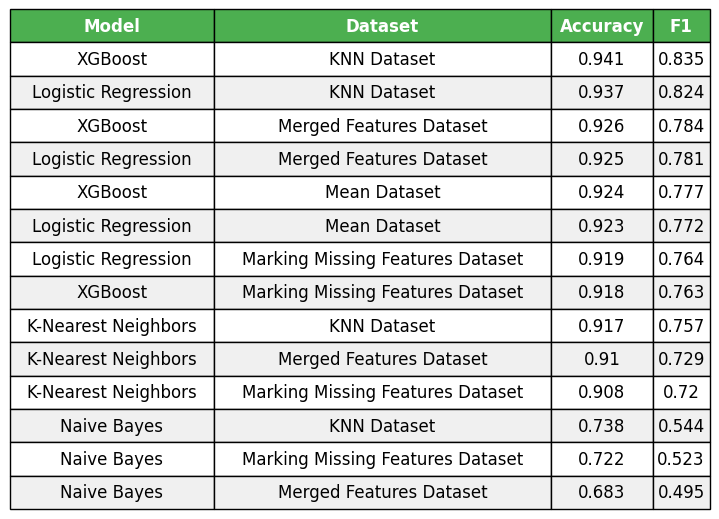

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your data and prepare the reduced DataFrame
final_results = pd.read_csv("results.csv")
final_results.sort_values(by='F1', ascending=False, inplace=True)
final_results_reduced = final_results.drop(columns=['Precision', 'Recall', 'ROC_AUC'])

# Round F1 and Accuracy to 3 decimals
final_results_reduced['F1'] = final_results_reduced['F1'].round(3)
final_results_reduced['Accuracy'] = final_results_reduced['Accuracy'].round(3)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(7, 4))  # Larger size for better readability
ax.axis('off')  # Turn off the axis

# Create the table
table = ax.table(
    cellText=final_results_reduced.values,
    colLabels=final_results_reduced.columns,
    cellLoc='center',
    loc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)  # Larger font size for better readability
table.auto_set_column_width(col=list(range(len(final_results_reduced.columns))))

table.scale(2, 2)  # Scale table width and height (1.5x default size)

# Add colors to header and alternate row colors
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#4CAF50')  # Green header background
    elif key[0] % 2 == 0:  # Alternate row colors
        cell.set_facecolor('#f0f0f0')  # Light gray for even rows
    else:
        cell.set_facecolor('#ffffff')  # White for odd rows

# Save the table as a PNG
plt.savefig("models_performances.png", dpi=300, bbox_inches='tight')
plt.show()


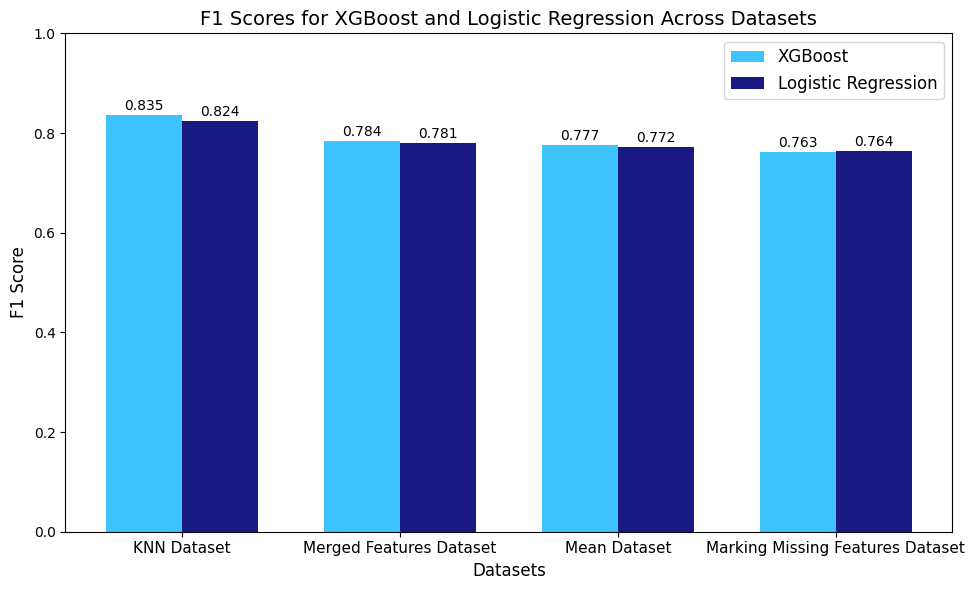

In [65]:
# Filter for only XGBoost and Logistic Regression models
filtered_results = final_results[
    (final_results['Model'] == 'XGBoost') | (final_results['Model'] == 'Logistic Regression')
]

# Pivot the data to organize by dataset and model
pivot_results = filtered_results.pivot(index='Dataset', columns='Model', values='F1')
pivot_results['Max_F1'] = pivot_results.max(axis=1)
pivot_results.sort_values(by='Max_F1', ascending=False, inplace=True)
pivot_results.drop(columns=['Max_F1'], inplace=True)

# Prepare data for plotting
datasets = pivot_results.index.tolist()
xgboost_f1 = pivot_results['XGBoost'].tolist()
logreg_f1 = pivot_results['Logistic Regression'].tolist()

# Plot settings
bar_width = 0.35
x = np.arange(len(datasets))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for XGBoost and Logistic Regression
xgboost_bars = ax.bar(x - bar_width/2, xgboost_f1, bar_width, label='XGBoost', color='#29BDFD', alpha=0.9)
logreg_bars = ax.bar(x + bar_width/2, logreg_f1, bar_width, label='Logistic Regression', color='#000077', alpha=0.9)

# Add value annotations on top of each bar
for bars in [xgboost_bars, logreg_bars]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', fontsize=10)

# Add labels, title, and legend
ax.set_xlabel('Datasets', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('F1 Scores for XGBoost and Logistic Regression Across Datasets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(datasets, fontsize=11)
ax.legend(fontsize=12)

# Set y-axis limits for better visual clarity
ax.set_ylim(0, 1)

# Show the plot
plt.tight_layout()
plt.savefig("datasets_performances.png", dpi=300)
plt.show()

## PCA

In [88]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def apply_pca(dataset, n_components=None):
    """
    Perform PCA on the given dataset, while removing 'id', 'Name', and 'Depression' columns,
    applying PCA, and then adding back 'id', 'Name' as the first columns and 'Depression' as the last column.
    
    :param dataset: DataFrame, input dataset
    :param n_components: int or float, number of components or variance threshold (e.g., 0.95)
    :return: DataFrame, PCA-transformed dataset with additional columns
    """
    if not all(col in dataset.columns for col in ['id', 'Name', 'Depression']):
        raise ValueError("Dataset must contain 'id', 'Name', and 'Depression' columns.")
    
    retained_columns = dataset[['id', 'Name', 'Depression']]
    
    feature_columns = dataset.drop(columns=['id', 'Name', 'Depression'])
    
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(feature_columns)
    
    pca_columns = [f'PC{i+1}' for i in range(pca_data.shape[1])]
    pca_df = pd.DataFrame(pca_data, columns=pca_columns)
    
    final_df = pd.concat([retained_columns.reset_index(drop=True), pca_df], axis=1)
    
    return final_df, pca

In [96]:
knn_dataset_pca = pd.read_csv("datasets/knn_dataset_pca.csv").sample(frac=1).reset_index(drop=True)
y_knn_pca = knn_dataset_pca['Depression'].to_numpy()
x_knn_pca = knn_dataset_pca.drop(columns=['id', 'Name', 'Depression']).to_numpy()
knn_pca_feature = knn_dataset_pca.drop(columns=['Depression', 'id', 'Name']).columns.tolist()

Running GridSearch for XGBoost on KNN PCA Dataset
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [18:10:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.10/site-packages/xgboost/core.p

Best params for XGBoost on KNN PCA Dataset: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

XGBoost on KNN PCA Dataset Metrics:
Accuracy:
0.9379294006159677
----------------------------------------
Confusion Matrix:
[[16641   629]
 [  681  3154]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     17270
         1.0       0.83      0.82      0.83      3835

    accuracy                           0.94     21105
   macro avg       0.90      0.89      0.90     21105
weighted avg       0.94      0.94      0.94     21105

----------------------------------------
ROC AUC Score:
0.893001746175664
----------------------------------------
F1 Score:
0.8280388553426096
----------------------------------------
Precision:
0.8337298440391224
----------------------------------------
Recall:
0.8224250325945242
----------------------------------------


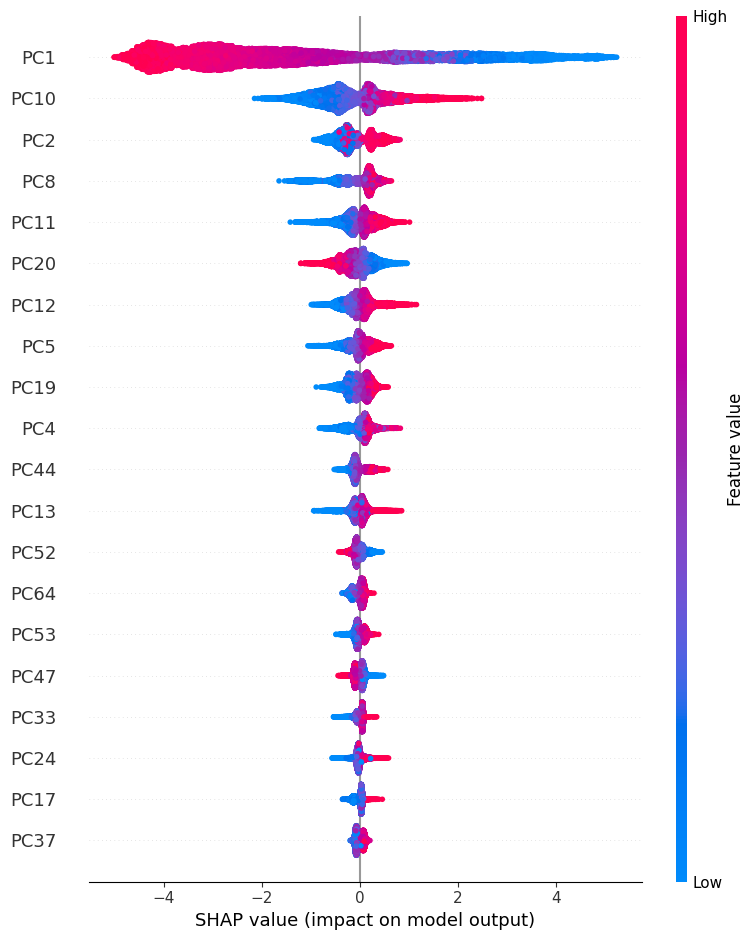

In [98]:
xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_model, xgb_metrics = tune_and_evaluate_model(models[2], xgb_param_grid, x_knn_pca, y_knn_pca, knn_pca_feature, "XGBoost", "KNN PCA Dataset")

Running GridSearch for Logistic Regression on KNN PCA Dataset
Fitting 5 folds for each of 128 candidates, totalling 640 fits


/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/opt/anaconda3/lib/python3.10/site-

Best params for Logistic Regression on KNN PCA Dataset: {'C': 1, 'l1_ratio': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression on KNN PCA Dataset Metrics:
Accuracy:
0.9357972044539209
----------------------------------------
Confusion Matrix:
[[16664   606]
 [  749  3086]]
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     17270
         1.0       0.84      0.80      0.82      3835

    accuracy                           0.94     21105
   macro avg       0.90      0.88      0.89     21105
weighted avg       0.93      0.94      0.94     21105

----------------------------------------
ROC AUC Score:
0.8848019302299772
----------------------------------------
F1 Score:
0.8199814002922812
----------------------------------------
Precision:
0.8358613217768147
----------------------------------------
Recall:
0.8046936114732725
-----------------------------------

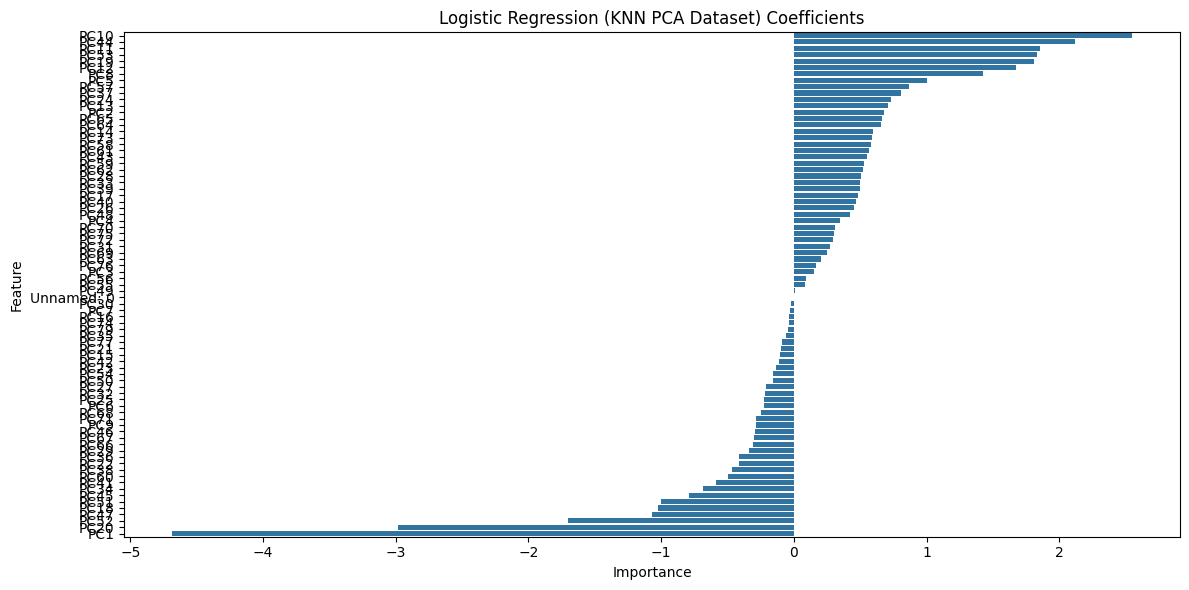

In [101]:
# Logistic Regression on Merged Dataset
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
    'l1_ratio': [0.1, 0.5, 0.7, 1.0]
}
lr_model, lr_metrics = tune_and_evaluate_model(models[0], lr_param_grid, x_knn_pca, y_knn_pca, knn_pca_feature, "Logistic Regression", "KNN PCA Dataset")